### Построение модели, проверка гипотез, выводы


In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 

from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [42]:
df = pd.read_csv('preprocessed_data.csv', index_col=0)

In [43]:
df_copy = df.copy(deep=True)

In [44]:
df.head()

,Name,Category,Country,Backers,State,Duration,Log_Goal,Backers_quantile,Bin_State
0,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,United States,30,Failed,40,6.908755,2,0
1,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,United States,3,Failed,88,11.289794,1,0
2,drawing for dollars,Art,United States,3,Successful,9,3.044522,1,1
3,Offline Wikipedia iPhone app,Technology,United States,25,Successful,80,4.605170,2,1
4,Pantshirts,Fashion,United States,10,Failed,29,7.550135,1,0


Уберем лишние столбцы

In [45]:
df = df.drop(labels=['Name', 'State', 'Backers'], axis=1)

Закодируем категориальные переменные, которые мы будем использовать в модели

In [46]:
categorical = ['Category', 'Country', 'Backers_quantile']

df = pd.get_dummies(df, columns=categorical, drop_first=True, dtype=int)

#### Мультиколлинеарность
Нестрогая мультиколлинеарность не мешает получению состоятельных и несмещенных оценок, но все же отметим, что в нашей модели показатели в основном VIF невысокие

In [47]:
x = df.drop(labels='Bin_State', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

                   feature        VIF
0                 Duration   8.314629
1                 Log_Goal  25.219520
2          Category_Comics   1.351544
3          Category_Crafts   1.257319
4           Category_Dance   1.127393
5          Category_Design   1.980711
6         Category_Fashion   1.695496
7    Category_Film & Video   3.093331
8            Category_Food   1.826656
9           Category_Games   2.063139
10     Category_Journalism   1.147053
11          Category_Music   2.621587
12    Category_Photography   1.329942
13     Category_Publishing   2.229246
14     Category_Technology   2.111335
15        Category_Theater   1.368390
16         Country_Austria   1.037406
17         Country_Belgium   1.037895
18          Country_Canada   1.856825
19         Country_Denmark   1.063297
20          Country_France   1.187773
21         Country_Germany   1.254918
22       Country_Hong Kong   1.036159
23         Country_Ireland   1.047822
24           Country_Italy   1.180645
25          

Построим модель на таких данных

#### Гетероскедастичность 
По умолчанию, мы используем в модели стандартные ошибки в форме Уайта, чтобы избежать гетероскедастичности.

#### Модель

In [48]:
y = df['Bin_State']
x = df.drop(labels='Bin_State', axis=1)
x = sm.add_constant(x)

model = sm.Logit(y, x).fit(cov_type='HC0')

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.227279
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              Bin_State   No. Observations:               331462
Model:                          Logit   Df Residuals:                   331421
Method:                           MLE   Df Model:                           40
Date:                Fri, 26 May 2023   Pseudo R-squ.:                  0.6631
Time:                        22:48:51   Log-Likelihood:                -75334.
converged:                       True   LL-Null:                   -2.2358e+05
Covariance Type:                  HC0   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.7672      0.084     45.095      0.000       3.603     

Первое, что хочется отметить -  регрессия в целом значима: значение LLR p - value близко к нулю.
<br/><br/>
Коэффициенты при заявленной цели по объему собираемых средств (Log_goal), продолжительности проекта (Duration), и при категориях проекта оказались значимы (p - value близко к нулю). Отсюда следует, что мы не отвергаем гипотезы о значимости этих характеристик для успешности проекта, которые мы и хотели проверить. 
<br/><br/>
Мы делаем вывод, что цель по объему средств влияет на успех проекта значимо отрицательно, продолжительность проекта влияет значимо отрицательно, принадлежность проекта к категориям Dance, Film & Video, Music и Theater значимо положительно влияет на его успешность. Принадлежность проекта к остальным категориям оказывает значимое негативное влияние на его успех.


#### ROC-AUC метрика и Precision-Recall Curve

In [49]:
y_pred = model.predict(x)

AUC-PR: 0.94437
AUC-ROC: 0.96603


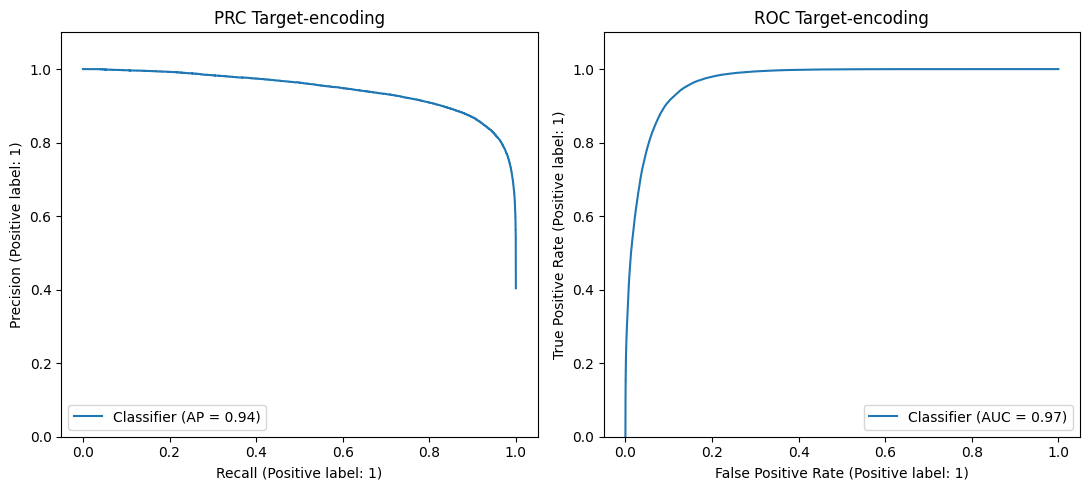

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC Target-encoding")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y, y_pred))
ax[1].set_title("ROC Target-encoding")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Метрики близки к 1, а значит наша модель неплоха

#### Предельные эффекты

In [16]:
model.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Bin_State
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Duration                  -0.0007    3.8e-05    -18.638      0.000      -0.001      -0.001
Log_Goal                  -0.0987      0.000   -282.508      0.000      -0.099      -0.098
Category_Comics           -0.0618      0.003    -21.378      0.000      -0.067      -0.056
Category_Crafts           -0.0519      0.004    -14.595      0.000      -0.059      -0.045
Category_Dance             0.0672      0.004     15.602      0.000       0.059       0.076
Category_Design           -0.0492      0.002    -21.128      0.000      -0.054      -0.045
Category_Fashion          -0.0329      0.003    -12.972      0.000      -0.038      -0.028
Category_Film & Video      0.0278      0.002     14.322      0.000       0.024       0.032
Category_Food             -0.0400      0.002    -16.090      0.000      -0.045      -0.035
Category_Games            -0.0801      0.002    -35.124      0.000      -0.085      -0.076
Category_Journalism       -0.0198      0.005     -4.216      0.000      -0.029      -0.011
Category_Music             0.0252      0.002     12.687      0.000       0.021       0.029
Category_Photography      -0.0145      0.003     -4.716      0.000      -0.020      -0.008
Category_Publishing       -0.0330      0.002    -15.279      0.000      -0.037      -0.029
Category_Technology       -0.0234      0.003     -9.175      0.000      -0.028      -0.018
Category_Theater           0.0633      0.003     21.961      0.000       0.058       0.069
Country_Austria            0.0075      0.015      0.502      0.616      -0.022       0.037
Country_Belgium            0.0247      0.014      1.786      0.074      -0.002       0.052
Country_Canada             0.0073      0.004      1.693      0.090      -0.001       0.016
Country_Denmark            0.0374      0.009      4.013      0.000       0.019       0.056
Country_France             0.0408      0.006      6.282      0.000       0.028       0.054
Country_Germany            0.0051      0.006      0.836      0.403      -0.007       0.017
Country_Hong Kong          0.0745      0.014      5.318      0.000       0.047       0.102
Country_Ireland            0.0011      0.011      0.103      0.918      -0.021       0.023
Country_Italy             -0.0013      0.008     -0.164      0.870      -0.017       0.014
Country_Japan              0.0272      0.053      0.517      0.605      -0.076       0.130
Country_Luxembourg         0.0182      0.038      0.479      0.632      -0.056       0.092
Country_Mexico            -0.0043      0.008     -0.538      0.590      -0.020       0.011
Country_Netherlands        0.0146      0.007      2.061      0.039       0.001       0.028
Country_New Zealand    -1.686e-05      0.008     -0.002      0.998      -0.016       0.016
Country_Norway             0.0143      0.014      1.034      0.301      -0.013       0.041
Country_Singapore         -0.0002      0.014     -0.016      0.987      -0.028       0.028
Country_Spain             -0.0053      0.008     -0.687      0.492      -0.020       0.010
Country_Sweden            -0.0009      0.007     -0.119      0.906      -0.015       0.014
Country_Switzerland        0.0673      0.012      5.410      0.000       0.043       0.092
Country_United Kingdom     0.0171      0.004      4.444      0.000       0.010       0.025
Country_United States      0.0209      0.004      5.854      0.000       0.014       0.028
Backers_quantile_1         0.3444      0.004     82.484      0.000       0.336       0.353
Backers_quantile_2         0.60

### Проверка спецификации модели

В качестве подвыборок для проверки устойчивости модели возьмем проекты по разным группам стран - США, Европа, Азия и др. При этом, США, Великобритания, Канада выделяются отдельно, так как в этих странах очень популярен Кикстартер, соответственно, в нашей выборке много проектов из этих стран

In [53]:
df['Country'].value_counts()

Country
United States     261358
United Kingdom     29453
Canada             12370
Australia           6616
Germany             3436
France              2520
Netherlands         2411
Italy               2369
Spain               1873
Sweden              1509
Mexico              1411
New Zealand         1274
Denmark              926
Ireland              683
Switzerland          652
Norway               582
Belgium              523
Austria              485
Hong Kong            477
Singapore            454
Luxembourg            57
Japan                 23
Name: count, dtype: int64

In [51]:
df = df_copy
df = df.drop(labels=['Name', 'State', 'Backers'], axis=1)
categorical = ['Category', 'Backers_quantile']
df = pd.get_dummies(df, columns=categorical, drop_first=True, dtype=int)


In [52]:
def cat_country(cntry):
    EU = [
        'Austria', 'Belgium', 'Denmark', 'France', 'Germany', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands ', 
        'Norway', 'Spain', 'Sweden', 'Switzerland'
    ]
    OTHER = [
        'Hong Kong', 'Japan', 'Singapore', 'New Zealand', 'Mexico', 'Australia'
    ]
    if cntry in EU:
        return 'Europe'
    elif cntry in OTHER:
        return 'Other'
    
    return cntry

df['Country_group'] = df['Country'].apply(cat_country)

In [54]:
df['Country_group'].value_counts()

Country_group
United States     261358
United Kingdom     29453
Europe             18026
Canada             12370
Other              10255
Name: count, dtype: int64

#### Построим логит-модели на этих подвыборках

In [55]:
for group in df['Country_group'].unique():
    sub_df = df[df['Country_group']==group]
    y = sub_df['Bin_State']
    x = sub_df.drop(labels=['Bin_State', 'Country', 'Country_group'], axis=1)
    x = sm.add_constant(x)

    model = sm.Logit(y, x).fit(cov_type='HC0')

    print(f'Логит-модель для подвыборки стран из группы {group}')
    print(model.summary())

Optimization terminated successfully.
         Current function value: 0.230150
         Iterations 10
Логит-модель для подвыборки стран из группы United States
                           Logit Regression Results                           
Dep. Variable:              Bin_State   No. Observations:               261358
Model:                          Logit   Df Residuals:                   261338
Method:                           MLE   Df Model:                           19
Date:                Fri, 26 May 2023   Pseudo R-squ.:                  0.6614
Time:                        22:55:39   Log-Likelihood:                -60152.
converged:                       True   LL-Null:                   -1.7765e+05
Covariance Type:                  HC0   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4

На всех подвыборках мы получили качественно те же результаты, что и при оценке изначальной модели: цель по объему средств влияет на успех проекта значимо отрицательно, так же как и продолжительность проекта, принадлежность проекта к категориям Dance, Film & Video, Music и Theater значимо положительно влияет на его успешность. Принадлежность проекта к остальным категориям оказывает значимое негативное влияние на его успех. Это говорит об устойчивости модели к разным спецификациям.

#### Эндогенность и инструментальные переменные

Как мы уже упоминали ранее, в модели, очевидно, есть пропущенные переменные. Если бы в фокусе нашей работы была эндогенность, мы бы постарались решить эту проблему с помощью инструментальных переменных.
<br/><br/>
Например, в качестве инструмента можно было бы взять индекс Business Environment, доступный на сайте The economist, отражающий уровень благоприятности условий в стране для бизнеса и предпринимательских инициатив. Он связан с объясняемой переменной и регрессором Country, но не связан ни с одной из известных нам пропущенных переменных: нишей проекта, организационной формой, опытом и активностью краундфандера, качеством презентации, вовлеченностью инвестора и т.д.

In [58]:
import graphviz as gr

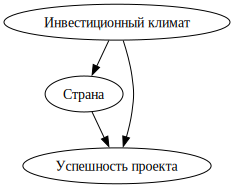

In [59]:
g = gr.Digraph()

g.edge('Инвестиционный климат', 'Страна')
g.edge('Инвестиционный климат', 'Успешность проекта')
g.edge('Страна', 'Успешность проекта')
g